# Basic API for qttpdesolver package (1D case).

For illustration, we consider below the following solvers 

- Solver-FS (a new Finite Sum solver)

- Solver-FD (a Finite Difference solver) 

for 1D stationary diffusion type PDE with scalar coefficient.

### First of all, we have to import  the main classes, functions and constants:

- Pde - is a class that represent equation. It collect benchmarks (prepared model PDEs), coefficients and parameters of calculation. The calculation results are also stored (automatically) in the instance of this class.

- create_solver - is a function for construction of the Solver class instance according to selected solver type and calculation mode.

- auto_solve - is a very usefull function that perfom all required steps to solve PDE and prepare results (if it is not used, then special functions like prep_solution, prep_derivative, prep_uu and prep_uf should be called explicitly).

- MODE_NP, MODE_TT, MODE_SP - are the constants that indicate the mode of calculation (numpy or tensor train or scipy sparse respectively). Note: MODE_SP is not available for the SolverFs. 

- SOLVER_FS, SOLVER_FD - are the constants that indicate the solver type.

In [1]:
%matplotlib inline
import numpy as np

from qttpdesolver import Pde, create_solver, auto_solve
from qttpdesolver import MODE_NP, MODE_TT, MODE_SP, SOLVER_FS, SOLVER_FD

### We'll also import some additional functions (only for test perposes):

(this functions are called from auto_solve function automatically)

In [2]:
from qttpdesolver.solve import prep_solution, prep_derivative, prep_uu, prep_uf

### Now we'll construct a PDE:

(model parameters should be set explicitly)

In [3]:
PDE = Pde()
PDE.txt = 'Simple 1D PDE for test' # It will be used in results representation
PDE.dim = 1                        # Dimension of the spatial variable
PDE.L   = 1.                       # Domain size (this variable is not used in current version: L=1 always)
 
# We set functions for coefficient k, rhs
# and analytic solution and derivatives of the model PDE (-1.)*div (k grad u) = f
# (all functions should have the same arguments)

def k_func(x, w1):
    return 1. + x

def f_func(x, w1):
    s1 = np.sin(w1*x)
    c1 = np.cos(w1*x)
    return w1*w1*(1.+x)*s1 - w1*c1

def u_func(x, w1):
    return np.sin(w1*x)

def ux_func(x, w1):
    return w1*np.cos(w1*x)

# And now we set this functions as parameters of PDE class instance
# (txt descriptions will be used for output)

PDE.k_txt = 'k  = 1+x'
PDE.k = k_func

PDE.f_txt = 'f  = w_1^2 (1+x) sin(w_1 x) - w_1 cos(w_1 x)'
PDE.f = f_func

PDE.u_txt = 'u  = sin(w_1 x)'
PDE.u = u_func   # analytical solution

PDE.ux_txt = 'ux = w_1 cos(w_1 x)'
PDE.ux = ux_func # analytical du/dx

# We also set parameters values and text description
PDE.params_txt = 'w1 [=%-8.4f]'
PDE.set_params([np.pi/PDE.L * 2])

# This function present current model
PDE.present_model()

PDE:        Simple 1D PDE for test
Parameters: w1 [=6.2832  ]
k  = 1+x
f  = w_1^2 (1+x) sin(w_1 x) - w_1 cos(w_1 x)
u  = sin(w_1 x)
ux = w_1 cos(w_1 x)



### Compact form

The code from the previous cell may be rewritten in a more compact form if we use a model from gallery:

In [4]:
PDE = Pde()
PDE.present_models()
print '-'*50
PDE.set_model('Simple. Analyt 1D diffusion PDE') # number (0) or name of the model may be used
PDE.set_params([np.pi*2])                        # default values of parameters can be changed
PDE.present_model()

The following models are available:
Model # 0. Name: |Simple. Analyt 1D diffusion PDE|
   -div(k grad u) = f in [0, 1]; u_d = 0; u is known
Model # 1. Name: |Simple. Analyt 2D diffusion PDE|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; u is known
Model # 2. Name: |Simple. Analyt 3D diffusion PDE|
   -div(k grad u) = f in [0, 1]^3; u_d = 0; u is known
Model # 3. Name: |Simple. Msc 1D diffusion PDE|
   -div(k grad u) = f in [0, 1]; u_d = 0; k - 1d multiscale coeff.
Model # 4. Name: |Simple. Msc 2D diffusion PDE|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; k - 2d multiscale coeff.
Model # 5. Name: |Simple. Msc 3D diffusion PDE|
   -div(k grad u) = f in [0, 1]^3; u_d = 0; k - 3d multiscale coeff.
Model # 6. Name: |Simple. 1D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]; u_d = 0; f=1
Model # 7. Name: |Simple. 2D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; f=1
Model # 8. Name: |Simple. 3D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]^3; u_d =

### Next, we have to set parameters of the calculation:

In [5]:
PDE.set_mode(MODE_TT)            # Calculation mode ('np': numpy, 'tt':tensor train or 'sp': scipy sparse)
                                 # (Note: MODE_SP is not available for Solver-FS)
PDE.set_solver_txt(SOLVER_FS)    # Name of the solver (SOLVER_FS='fs' or SOLVER_FD='fd')
                                 # (if auto_solve is used then solver will be selected from this var.
PDE.set_verb(verb_gen=True,      # If is True then general info will be printed
             verb_crs=False,     # If is True then cross approximation info will be printed
             verb_lss=False)     # If is True then lin. syst. solver info will be printed
PDE.set_tau(tau=1.E-10,          # Accuracy for tt-representation
            eps_lss=1.E-10,      # Accuracy for linear system solver iterations, 
            tau_lss=1.E-10)      # Accuracy for linear system solver resulting rounding
                                 # (if tau_lss is None, then real accurace of solver will be used)
                                 # There is one more parameter tau_real (=tau*1.E-2 by default),
                                 # that is the accuracy for construction of analytical solution
PDE.set_lss_params(nswp=20,      # Settings for linear system solver
                   kickrank=4, 
                   local_prec='n', 
                   local_iters=2,
                   local_restart=20, 
                   trunc_norm=1, 
                   max_full_size=100)
PDE.present_info()               # This function prints current settings

__________________General parameters
Mode          : tt
Solver        : fs
Model num     : 0 
Parameters    : w1 [=6.2832  ]
__________________Verbosity parameters
verb_gen      : True
verb_crs      : False
verb_lss      : False
print_to_std  : True
print_to_file : False
__________________TT parameters
tau           : 1.00e-10
eps_lss       : 1.00e-10
tau_lss       : 1.00e-10
tau_real      : 1.00e-12
lss: nswp     : 20  
lss: kickrank : 4   
lss: use sol0 : False



### PDE solution:

In [7]:
# We set value of d. This function also recalculates
# n=2**d (a number of grid nodes along one axis) and h=L/n (grid step) (L=1).
PDE.update_d(20)

# We remove results of the previous calculations (it's necessary only for the case
# then the same PDE instance is used for several calculations):
PDE.clean()

# We create solver class instance and explicitly call 4 main functions:
PDESolver = create_solver(PDE)
PDESolver.gen_coefficients()
PDESolver.gen_matrices()
PDESolver.gen_system()
PDESolver.gen_solution()
# We can call only one function instead gen_* functions:
#PDESolver.solve() 

# This functions calculate errors, eranks, derivatives and so on:
prep_solution(PDE)
prep_derivative(PDE)
prep_uu(PDE)
prep_uf(PDE, PDESolver)
    
# This function presents result in a one string mode:
PDE.present_res_1s()

Time of coeffs.  generation: 0.1848  
Time of matrices generation: 0.0043  
Time of system generation  : 0.0000  
Time of system solving     : 0.0141  
d=20|fs-tt|er=3.1e-12 |erdx=4.7e-11 |T=0.203  |R=2.0  |It=0 


### Compact form:

The code from the previous cell may be rewritten in a more compact form if we use an auto_solve function:

In [8]:
PDE.update_d(20)
PDE.set_verb(verb_gen=True, verb_crs=False, verb_lss=True) 
PDESolver = auto_solve(PDE, return_solver=True)

Time of coeffs.  generation: 0.2456  
Time of matrices generation: 0.0040  
Time of system generation  : 0.0000  
Time of system solving     : 0.0155  
Time of additional calcs.  : 0.2427  
d=20|fs-tt|er=3.1e-12 |erdx=4.7e-11 |T=0.265  |R=2.0  |It=0 


### The output in the 1-string mode has the following sense:
- d=20 - is a factor of grid size (n=2^d),
- fs-tt - is a name of the used solver and a calculation mode,
- er=3.1e-12 - is the error of solution vs analytical (if it's known),
- erdx=4.7e-11 - is the error of x-derivative vs analytical (if it's known),
- T=0.265 - is the time of calculation in seconds (an exact numerical values may depend on work station, which is used for computations),
- R=2.0 - is the e-rank of the calculated solution (since random restart in AMEn-solver is used, the rank can vary within a small range),
- It=0 - is a number of AMEn iterations (FS-QTT-Solver in 1D don't use AMEn solver, since explicit formula is available),

### Then we can present the calculation results:

PDE                : -div(k grad u) = f in [0, 1]; u_d = 0; u is known
PDE mode           : tt
Used PDE solver    : fs
PDE dimension      : 1   
Value of d         : 20  
Mesh 1D size       : 1048576
Solution erank     : 1.96  
Analit. sol. erank : 1.96  
Solution error     : 3.07e-12
X-derivative error : 4.72e-11
(u, f) real        : 29.6088132033   
(u, f) calc        : 29.6088132034   
(u, f) err         : 3.00e-12
Solver iterations  : 0   
Time: coeff.   (s.): 0.2456  
Time: matrices (s.): 0.0040  
Time: system   (s.): 0.0000  
Time: system   (s.): 0.0155  
Total time     (s.): 0.2651  
*Time: prep.   (s.): 0.2427  



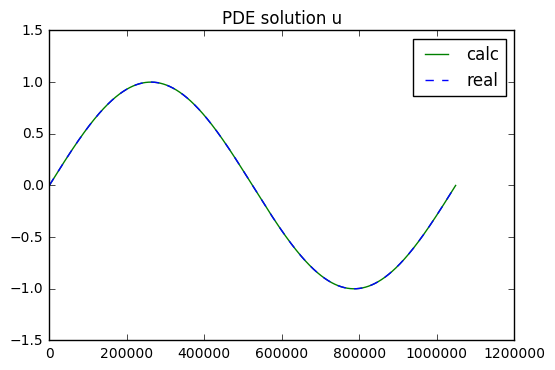

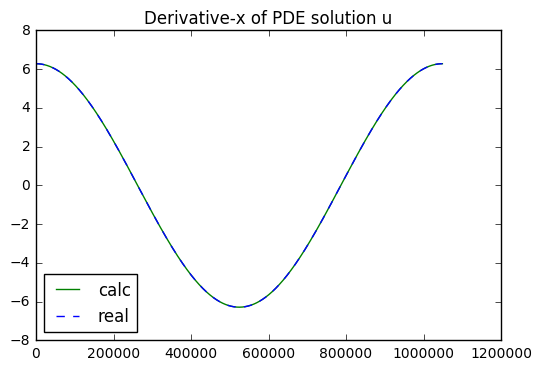

In [9]:
PDE.present_res()
PDE.plot_res()

### The following variables and values are saved in Pde class instance after calculation (some of them may be None):

- Linear system solver parameters (iters and so on) (for SOLVER_FD in MODE_TT)
- Effective ranks of the main vectors and matrices: r['A'], r['rhs'], ... (in MODE_TT)
- Calculated solution: u_calc, u_calc_ranks (for MODE_TT)
- Analytical solution: u_real, u_real_ranks (for MODE_TT)  and the error u_err
- Calculated derivative: ux_calc
- Analytical derivative: ux_real and the error ux_err
- Functional (u, u): uu_calc, uu_real, uu_err
- Functional (u, f): uf_calc, uf_real, uf_err
- Times of the main operations (t['cgen'], ...) and t_full

In [11]:
print PDE.u_calc
print PDE.u_real
print PDE.ux_calc
print PDE.ux_real
print PDE.uu_calc

 tt-vector |u_calc|             [tau=1.00e-10] {d=20} (erank=  2.0)
 tt-vector |u_real|             [tau=1.00e-10] {d=20} (erank=  2.0)
 tt-vector |ux_calc|            [tau=1.00e-10] {d=20} (erank=  3.2)
 tt-vector |ux_real|            [tau=1.00e-10] {d=20} (erank=  2.0)
0.500000000003


### The following variables are saved in PDESolver class instance (for Solver_FS) after calculation:

In [12]:
print PDESolver.f
print PDESolver.iKx
print PDESolver.Bx

 tt-vector |f|                  [tau=1.00e-10] {d=20} (erank=  3.3)
 tt-matrix |iKx|                [tau=1.00e-10] {d=20} (erank=  3.0)
 tt-matrix |Bx|                 [tau=1.00e-10] {d=20} (erank=  2.0)


### Note that all variables have type Vector or Matrix from subpackage tensor_wrapper.

This is format-free representation of arrays (operations in MODE_NP, MODE_TT and MODE_SP have the same form in this format). 

If one needs numpy array, then to_np property should be called (it works only for moderate d values).

Property to_tt converts Vector or Matrix class instance to tt-format. 

Otherwise the .x property may be used - it contains the np.ndarray or tt.vector or tt.matrix or scipy.sparse scr matrix.

In [13]:
print type(PDESolver.f)
f_tt = PDESolver.f.to_tt
print type(f_tt)
f_np = PDESolver.f.to_np
print type(f_np)
print f_np.shape
print type(PDESolver.f.x)

<class 'qttpdesolver.tensor_wrapper.vector.Vector'>
<class 'tt.core.vector.vector'>
<type 'numpy.ndarray'>
(1048576,)
<class 'tt.core.vector.vector'>


### And now let perform the same calculation for Solver-FD in MODE_TT in a compact form

Note, SOLVER_FD is not accurate for huge d values. So, for the selected d(=20) we have the higher error of the solution, than for the case of the SOLVER_FS.

In [1]:
%matplotlib inline
import numpy as np

from qttpdesolver import Pde, auto_solve
from qttpdesolver import MODE_NP, MODE_TT, MODE_SP, SOLVER_FS, SOLVER_FD

In [2]:
PDE = Pde()

PDE.set_model('Simple. Analyt 1D diffusion PDE')
PDE.set_params([np.pi*2])
PDE.set_mode(MODE_TT)
PDE.set_solver_txt(SOLVER_FD)
PDE.set_verb(True, True, True)
PDE.set_tau(tau=1.E-10, eps_lss=1.E-10, tau_lss=1.E-10)
PDE.set_lss_params(nswp=20, kickrank=4, local_prec='n', local_iters=2,
                   local_restart=20, trunc_norm=1, max_full_size=100)
PDE.update_d(20)
PDESolver = auto_solve(PDE, return_solver=True)

  Construction of Kx
=multifuncrs= sweep 1{2}, max_dy: 6.547e-01, erank: 6.245
=multifuncrs= sweep 2{1}, max_dy: 5.493e-16, erank: 6.245
  Construction of f
=multifuncrs= sweep 1{2}, max_dy: 1.013e+00, erank: 6.245
=multifuncrs= sweep 2{1}, max_dy: 1.352e-11, erank: 7.54983
Time of coeffs.  generation: 0.1927  
Time of matrices generation: 0.0069  
Time of system generation  : 0.0127  
amen_solve: swp=1, max_dx= 4.486E+04, max_res= 3.138E+08, max_rank=9
amen_solve: swp=2, max_dx= 7.041E-06, max_res= 7.552E-03, max_rank=13
amen_solve: swp=3, max_dx= 9.827E-06, max_res= 3.851E-04, max_rank=17
amen_solve: swp=4, max_dx= 1.809E-05, max_res= 4.052E-04, max_rank=21
amen_solve: swp=5, max_dx= 6.961E-06, max_res= 2.215E-04, max_rank=25
amen_solve: swp=6, max_dx= 1.087E-05, max_res= 5.308E-04, max_rank=29
amen_solve: swp=7, max_dx= 9.272E-06, max_res= 2.720E-04, max_rank=33
amen_solve: swp=8, max_dx= 3.843E-06, max_res= 3.268E-04, max_rank=37
amen_solve: swp=9, max_dx= 8.205E-06, max_res= 4.165

PDE                : -div(k grad u) = f in [0, 1]; u_d = 0; u is known
PDE mode           : tt
Used PDE solver    : fd
PDE dimension      : 1   
Value of d         : 20  
Mesh 1D size       : 1048576
Solution erank     : 4.01  
Analit. sol. erank : 1.96  
Solution error     : 7.28e-05
X-derivative error : 5.23e-02
(u, f) real        : 29.6088132033   
(u, f) calc        : 29.6087587280   
(u, f) err         : 1.84e-06
Solver iterations  : 20  
Matrix A erank     : 4   
Vector rhs erank   : 4   
Time: coeff.   (s.): 0.1927  
Time: matrices (s.): 0.0069  
Time: system   (s.): 0.0127  
Time: system   (s.): 6.9168  
Total time     (s.): 7.1291  
*Time: prep.   (s.): 0.1859  



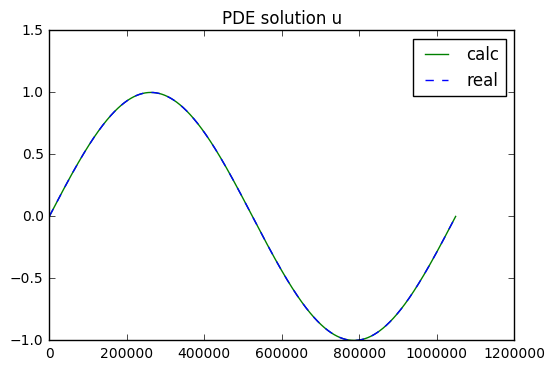

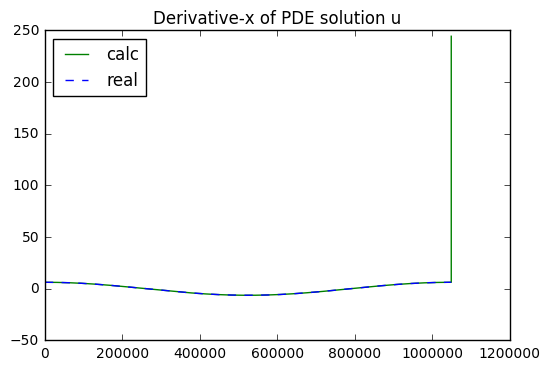

In [3]:
PDE.present_res()
PDE.plot_res()